# N-Body Force Simulation(s)
Max Coy EPS 109 Final Project (Fall 2021)

This is a 'brute force' (i.e. essentially n^2 operations) n-body simulator. Intended to solve ODE's and not recommended for particle counts > 200 (at least on my laptop). Particle collisions are handled by joining any overlaping particles regardless of the actual physicality however some care is made to preserve linear momentum (i.e. it's handled very crudely). Integration will make use of the 4th order Runge-Kutta method.

Importing necessary packages

In [1]:
import datetime
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#Setting up FFMpeg
from matplotlib.animation import FFMpegWriter
plt.rcParams['animation.ffmpeg_path']=r'C:\FFmpeg\bin\ffmpeg.exe' #pathing is specific to my (Max Coy) computer

FFMpeg will be used to create animations for my project submission but is not actually required to run any simulations. With that said, as it's wrapped around the simulate() function, some slight modifications will need to be made to run without FFMpeg

Defining main object class to keep track of particle specific parameters for code as well as some quality of life functions

In [2]:
class particle():
    def __init__(self, pos, vel, mass, special):
        self.r = pos #position of center of mass
        self.v = vel #should have same dimensions as pos
        self.m = mass
        self.size = (0.75 * self.m / np.pi)**(1/3) #radius of particle (assuming desnity of 1)
        self.spc = special #free parameter to play around with
      

    #adds one particle to another, combining parameters
    def join(self, pc): 
        #setting position at center of mass
        self.r = (self.m*self.r + pc.m*pc.r) / (self.m + pc.m)
        #using momentum to calculate new velocity
        p = self.v * self.m + pc.v * pc.m
        self.m += pc.m
        self.v = p / self.m
        self.size = (0.75 * self.m / np.pi)**(1/3)
        self.spc += pc.spc #treating the free parameter like charge
        return self

#computes distance of C.O.M. to another particle
    def dist(self,pc):
        return np.linalg.norm(self.r-pc.r)
    
#determines if 2 particles overlap / touching, compares joint radii to C.O.M. distance
    def col(self,pc):
        return (self.size+pc.size) >= self.dist(pc)
    
#Defining output string for convenience
    def __str__(self):
        out  = 'C.O.M. Position {} \n'.format(np.round(self.r,3))
        out += 'Current Velocity: {} \n'.format(np.round(self.v,3))
        out += 'Current Mass: {:.2f} \n'.format(self.m)
        out += 'Current Size: {:.2f} \n'.format(self.size)
        out += 'Current Special: {:.2f}'.format(self.spc)
        return out
    
#implementing dunder/magic methods to allow operations on numpy arrays. In order to allow for more freedom
#I'm going to adopt the following convention: +,-,*,/ operations take two particle objects, +=, -=, *=, /=
#operations take a particle object and an array with the correct length. The i operations may end up being 
#removed but due to the nature of programming I have already written them so I might as well include them
#for the time being. It should also be mentioned that these operations only affect position and velocity.
#join() has already been written and allows for manipulating the mass and special values
     
    def __add__(self,other):
        return particle(self.r+other.r, self.v+other.v, self.m, self.spc)
    
    def __sub__(self,other):
        return particle(self.r-other.r, self.v-other.v, self.m, self.spc)
        
    def __mul__(self,other):
        return particle(self.r*other.r, self.v*other.v, self.m, self.spc)
    
    def __truediv__(self,other):
        return particle(self.r/other.r, self.v/other.v, self.m, self.spc)
    
    def __iadd__(self,other):
        dim = len(self.r)
        return particle(self.r+other[0:dim],self.v+other[dim:2*dim],self.m,self.spc)
    
    def __isub__(self,other):
        return particle(self.r+other[0:dim],self.v+other[dim:2*dim],self.m,self.spc)
    
    def __imul__(self,other):
        return  particle(self.r*other,self.v*other,self.m,self.spc)
    
    def __itruediv__(self,other):
        #return particle(self.r/other,self.v/other,self.m,self.spc)
        return self / other

Next function takes a list of particles and joins any particles that might be overlaping/touching. After passing through, it is possible that particles that weren't touching originally are now so it makes a recursive call in the end should this be the case. Not sure how to do that cleanly though so this probably not the most effecient implementation but it works so it'll do for now

In [3]:
def col_adjust(particles):
    out = [particles[0]]
    particles = np.delete(particles,0)
    
    while len(particles) > 0:
        Free = True
        #checking to see if particle touches anything in out
        for i in range(len(out)):
            if particles[0].col(out[i]):
                #if particles touch then join them
                out[i] = out[i].join(particles[0])
                particles = np.delete(particles,0) 
                Free = False
                break
        
        #Runs if no collisions with current list
        if Free:
            out.append(particles[0])
            particles = np.delete(particles,0) 
        
    #checking to make sure no new particles overlap with increased size, turning off decreases runtime but
    #might lead to slightly different results as it potentially would allow particles to move while overlapping
    overlap = False
    for i in range(len(out)):
        for j in range(i+1,len(out)):
            if out[i].col(out[j]):
                overlap = True
                break
    
    if overlap: #recursive call in the event that there is some overlapping
        out = col_adjust(out)
        
    return np.array(out)

Defining Force Functions to be used by ODE solver

In [24]:
#Classic Gravitational Force, generalized to n dimensions, takes 2 particles as input
def fGravity(p1, p2):
    global G
    #Calculating Force
    d = p1.dist(p2)
    F = -G*p1.m*p2.m / (d*d) #returning r unit vector so only d^2
    
    #Calculating direction of force
    r = (p1.r - p2.r) / d #division by d makes the vector unit length
    
    return F, r

#Electric Force
def fCharge(p1,p2):
    global K
    #Calculating Force
    d = p1.dist(p2)
    F = K*p1.spc*p2.spc / (d*d) #returning r unit vector so only d^2
    
    #Calculating direction of force
    r = (p1.r - p2.r) / d #division by d makes the vector unit length
    
    return F, r

#Combination of Electric and Gravitational Force
def fGQ(p1,p2):
    global G, K
    #Calculating Force
    d = p1.dist(p2)
    F1 = -G*p1.m*p2.m / (d*d) #returning r unit vector so only d^2
    F2 = K*p1.spc*p2.spc / (d*d)
    #Calculating direction of force
    r = (p1.r - p2.r) / d #division by d makes the vector unit length
    
    return F1+F2, r

#Combinational of Gravitational Force and fictional repulsive force
def fBounce(p1,p2):
    global G, R
    d = p1.dist(p2)
    F1 = -G*p1.m*p2.m / (d*d) #Gravitational Force
    F2 = R*p1.m*p2.m / (d*d*d) #Fictional r^-3 repulsive force
    
    #Calculating direction of force
    r = (p1.r - p2.r) / d #division by d makes the vector unit length
    
    return F1+F2, r

#Fictional mass dependent linear force
def fLinearMass(p1,p2):
    global L
    d = p1.dist(p2)
    F = L * d * p1.m * p2.m
    r = (p1.r - p2.r) / d #division by d makes the vector unit length
    
    return F, r

#fictional special dependent linear force
def fLinearSpc(p1,p2):
    global L
    d = p1.dist(p2)
    F = L * d * p1.spc * p2.spc
    r = (p1.r - p2.r) / d #division by d makes the vector unit length
    
    return F, r

#Similar to linear mass force except the force is applied perpendicularly to the particle at set angle theta
def fSpiral(p1,p2):
    global L, theta
    d = p1.dist(p2)
    F = L * p1.m * p2.m * d
    
    #Getting initial r unit vector
    r = (p1.r - p2.r) / d #division by d makes the vector unit length
    
    #Finding angles that would correspond to spherical coordinates
    phi = np.arccos(r[-1])
    rTheta = np.arccos(r[0]/np.sin(phi))
    
    #Stealing some code from my tangentVector() function
    #Two orthonormal vectors which form a basis for the plane tangent to the sphere at point (r,theta,phi)
    b1 = np.array([np.cos(rTheta)*np.sin(phi+np.pi/2), np.sin(rTheta)*np.sin(phi+np.pi/2), np.cos(phi+np.pi/2)])
    b2 = np.array([np.cos(rTheta+np.pi/2)*np.sin(np.pi/2), np.sin(rTheta+np.pi/2)*np.sin(np.pi/2), np.cos(np.pi/2)])
    
    rotate = np.array([np.cos(theta),np.sin(theta)])

    #Mapping vector from x-y plane to tangent plane
    transform = b1*rotate[0] + b2*rotate[1]
    
    return F, transform

Defining Constants to be Used by Force Functions

In [5]:
G = 1e6 #Gravitational Force Constant
K = 1e6 #Electric Force Constant
R = 1e5 #Repulsive Force Constant (imaginary)
L = 1e5 #Linear Force Constant
theta = np.pi/2

Next function is an add on to the code to check and see if the timescale and force are a good fit. Not too much effort really invested into it tbh

In [6]:
def testForce(Particles,force,dt):
    dp = RungeKutta(force,dt,Particles)
    dv = []
    dr = []
    d = []
    v = []
    for i in range(1,len(Particles)): #skips the first index as convention to ignore potential sun object which gives 0's
        dv.append(np.linalg.norm(dp[i].v) / np.linalg.norm(Particles[i].v))
        dr.append(np.linalg.norm(dp[i].r) / np.linalg.norm(Particles[i].r))
        d.append(np.linalg.norm(Particles[i].r))
        v.append(np.linalg.norm(Particles[i].v))
    dv = np.mean(dv)
    dr = np.mean(dr)
    d = np.mean(d)
    v = np.mean(v)
    print('Average Position Magnitude of Particles: {}'.format(d))
    print('Average Velocity Magnitude of Particles: {}'.format(v))
    print('Average Change in Position Magnitude of Particles: {} %'.format(dr*100))
    print('Average Change in Velocity Magnitude of Particles: {} %'.format(dv*100))
    print('Average New Velocity to Average Position Ratio: {}'.format((dv+v)/d))

Defining main ODE solver, it takes time as a convention, a list of particle objects, and the force function used to act on them. In order to reduce computational load I am going to only do calculations 1 way, e.g. for any two particles i and j, we will take advantage of the fact that f(i,j) = -f(j,i) and only to the calculation once. 

This will be achieved with nested lists and the following rules: 
    
    for any particle n, it's positive forces appear in all of row n
    for any row k < n, a negative force appears in position n-k-1
  
In order to keep the solver general, it will be expected that any force function takes only 2 particles as its input, any other parameters must be either global variables or stored within the particle class. It will also be expected that any force function returns an r unit vector which points in the direction of the force, by doing so we allow for forces to apply themselves in any arbitrary direction theta between the particles 

In [7]:
def ODE(force, t, Particles):
    #Setting the change in position variables
    drdt = []
    for i in range(len(Particles)):
        drdt.append(Particles[i].v)
    drdt = np.array(drdt)
    #master lists which will contain the force of each interaction and unit vector
    Forces = []
    ForceR = []
    
    #nested for loops will give rise to the pattern stated above
    for i in range(len(Particles)): #last particle doesn't interact with itself, hence -1
        #temporary lists to be appended to the master lists at each step
        f = [] 
        r = []
        for j in range(i+1,len(Particles)):
            x, y = force(Particles[i],Particles[j])
            f.append(x)
            r.append(y)
        #numpy gets mad when the rows don't have equal dimension so i'm adding lists of 0 as a fix for now
        for j in range(0,i):
            f.append(0)
            r.append([0]*len(ForceR[0][0]))
        
        Forces.append(f)
        ForceR.append(r)
    Forces = np.array(Forces)
    ForceR = np.array(ForceR)
    
    #determining change velocity vector of each particle
    dvdt = []
    if(len(ForceR) > 1): #making sure that there is more than 1 particle
        #print(ForceR)
        for i in range(len(Particles)):
            vel = []
            #loops through each spatial dimension
            for j in range(len(Particles[i].v)):
                #adding row i
                v = np.dot(Forces[i],ForceR[i,:,j])
                #looping through all rows k < i
                for k in range(0,i):
                    v -= Forces[k][i-k-1]*ForceR[k][i-k-1][j] #negative forces
                vel.append(v)
            dvdt.append(vel)
        dvdt = np.array(dvdt)
        #theoretically the j loop could be hard-coded out however that would make it so that the ODE only solves
        #one particular dimension rather than being applicable to all possible spaces
    else:
        dvdt = [np.zeros(len(Particles[0].r))]
    #creating master list to hold all particle changes
    out = []
    for i in range(len(dvdt)):
        #The reason for using particle objects here is to take advantage of numpy array addition / multiplication
        out.append(particle(drdt[i],dvdt[i],0,0))
    return np.array(out)

Next I will be defining a function to carry out the Runge-Kutta Method

In [8]:
def RungeKutta(force, dt, Particles):
    #Creating Particle Objects to Use in Equations
    dim = len(Particles[0].r)
    arr = np.ones(dim)
    DT = particle(arr*dt,arr*dt,0,0)
    Two = particle(arr*2,arr*2,0,0)
    DT6 = particle(arr*dt/6,arr*dt/6,0,0)
    
    f1 = ODE(force,dt,Particles) #dt not actually need in ODE
    f2 = ODE(force,dt,Particles+f1*DT/Two)
    f3 = ODE(force,dt,Particles+f2*DT/Two)
    f4 = ODE(force,dt,Particles+f3*DT)
    
    #Due to the nature of magic methods, caution should be made that numpy arrays always come before particles
    #i.e. Two*f2 throws an error whilst f2*Two does not
    return (f1 + f2*Two + f3*Two + f4)*DT6

That's all the main functionality complete, next I will be defining some functions to help take care of plotting the data but the code should be able to run simulations now. While the simulations can be setup / run in any dimensions, the premade plotting functions are only for 3 so plotting / animating other dimensions will have to be done by hand

In [ ]:
def genParticle():
    r = 2
    while r > 1:
        x = 2 * np.rand() - 1
        y = 2 * np.rand() - 1
        z = 2 * np.rand() - 1
        r = x*x + y*y + z*z
    return r

In [15]:
#Defaults size to 1
size = 1

#plots a particle as a 3d wireframe sphere
def plotSphere(particle, divisions):
    theta, phi = np.mgrid[0:2*np.pi:2*np.pi/divisions,0:np.pi:np.pi/divisions]
    x = particle.size * np.cos(theta)*np.sin(phi) + particle.r[0]
    y = particle.size * np.sin(theta)*np.sin(phi) + particle.r[1]
    z = particle.size * np.cos(phi) + particle.r[2]
    
    ax.plot_wireframe(x,y,z) 

def plot(Particles, divisions):
    global size
    scaler = 1.5
    for i in range(len(Particles)):
        plotSphere(Particles[i], divisions)
    ax.set_xlim3d(-size*scaler,size*scaler)
    ax.set_ylim3d(-size*scaler,size*scaler)
    ax.set_zlim3d(-size*scaler,size*scaler);
    
def initPlot():
    global fig, ax
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(projection='3d')

def simulate(name,fps,resolution, pt, force, dt, iterations):
    global fig, ax
    ct = datetime.datetime.now()
    print ('Simulation began on: ',str(ct))

    metadata = dict(title='Simulations', artist='Matplotlib',comment='Code Written by Max Coy (2021)')
    writer = FFMpegWriter(fps=fps, metadata=metadata,bitrate=200000)
    initPlot()
    with writer.saving(fig,name,dpi=200):
        
        for i in range(iterations):
                if i % resolution == 0:
                    fig.clear()
                    ax = fig.add_subplot(projection='3d')
                    plot(pt, 16)
                    plt.draw()
                    writer.grab_frame();
                pt += RungeKutta(force,dt,pt)
                pt = col_adjust(pt)
                print('Current Iteration: {} \r'.format(i),end='')
    
    dt = datetime.datetime.now()
    print ('Simulation ended on: ',str(dt))
    print('Elapsed Time: ',str(dt-ct))
    

With all the backend complete, we can finally start generating sets of particles and running the simulations. I'm going to include a few functions to auto generate convienient sets

In [10]:
#Generates a uniform box distribution
def randomBox(N, dimension, positionR, velocityR, massR, specialR):
    #Determines size of box to graph things in
    global size 
    size = positionR
    #Creating Objects
    particles = []
    for i in range(N):
        r = (rand(dimension) - 0.5)*positionR 
        v = (rand(dimension) - 0.5)*velocityR 
        m = rand()*massR 
        spc = rand()*specialR
        particles.append(particle(r,v,m,spc))
    
    #Making sure no bodies are overlapping, due to this, function returns an array of particles with length <= N
    out = np.array(particles)
    out = col_adjust(out)
    return out

#Generates a spherical uniform particle distribution (only 3d)
def randomSphere(N, positionR, velocityR, massR, specialR):
    #Determines size of box to graph things in
    global size 
    size = positionR
    #Creating Objects
    particles = []
    for i in range(N):
        #Generating Random angles
        theta1 = rand()*2*np.pi 
        theta2 = rand()*2*np.pi 
        phi1 = rand()*np.pi
        phi2 = rand()*np.pi
        
        #Mapping angles to pos/velocities
        r = np.array([np.cos(theta1)*np.sin(phi1), np.sin(theta1)*np.sin(phi1), np.cos(phi1)])*positionR
        v = np.array([np.cos(theta2)*np.sin(phi2), np.sin(theta2)*np.sin(phi2), np.cos(phi2)])*velocityR
        m = rand()*massR 
        spc = rand()*specialR
        particles.append(particle(r,v,m,spc))
        
    #Making sure no bodies are overlapping, due to this, function returns an array of particles with length <= N
    out = np.array(particles)
    out = col_adjust(out)
    return out

#Function to be used by next distribution, generates a vector tangent to a point on a sphere in a random direction
def tangentVector(theta, phi):
    #Two orthonormal vectors which form a basis for the plane tangent to the sphere at point (r,theta,phi)
    b1 = np.array([np.cos(theta)*np.sin(phi+np.pi/2), np.sin(theta)*np.sin(phi+np.pi/2), np.cos(phi+np.pi/2)])
    b2 = np.array([np.cos(theta+np.pi/2)*np.sin(np.pi/2), np.sin(theta+np.pi/2)*np.sin(np.pi/2), np.cos(np.pi/2)])
    
    #Generating random vector in the x-y plane
    rho = rand()*2*np.pi
    v = np.array([np.cos(rho),np.sin(rho)])

    #Mapping vector from x-y plane to tangent plane
    transform = b1*v[0] + b2*v[1]
    
    return transform

#Another spherical distribution except all initial velocities are perpendicular to the origin (only 3d)
def orbitalSphere(N, positionR, velocityR, massR, specialR):
    #Determines size of box to graph things in
    global size 
    size = positionR
    #Creating Objects
    particles = []
    for i in range(N):
        #Generating Random angles
        theta = rand()*2*np.pi 
        phi = rand()*np.pi 
        #Mapping angles to pos/velocities
        r = np.array([np.cos(theta)*np.sin(phi), np.sin(theta)*np.sin(phi), np.cos(phi)])*positionR
        v = tangentVector(theta,phi)*velocityR
        m = rand()*massR 
        spc = rand()*specialR
        particles.append(particle(r,v,m,spc))
    
    #Making sure no bodies are overlapping, due to this, function returns an array of particles with length <= N
    out = np.array(particles)
    out = col_adjust(out)
    return out


#Essentially the same as orbitalSphere except with the addition of a massive body in the center, and more care given
#to the initial velocities so that the smaller bodies don't immeadiately fall into the center. In this case N refers
#to the number of objects orbiting the star. Given the specific geometry only coded for 3 dimensions. Force function is 
#specified to allow for proper calculation of initial velocities
def solarSystem(force, N, positionR, velocityVar, massR, specialR):
    global size 
    sun = particle(np.array([0,0,0]),np.array([0,0,0]), massR*1e6, specialR*1e6)#creating massive particle at origin
    pt = orbitalSphere(N, positionR, 1, massR, specialR)
    #adjusting velocities
    for i in range(len(pt)):
        pt[i].r *= 2
        F, r = force(sun,pt[i]) #force on sun and particle
        mu = (sun.m * pt[i].m) / (sun.m + pt[i].m) #reduced mass
        vMag =  np.sqrt(np.abs(F/mu * np.linalg.norm(pt[i].r)))#magnitude of force, abs is to prevent potential negatives
        v = (pt[i].v / np.linalg.norm(pt[i].v)) * vMag #normalizing and then scaling V
        var = (rand() - 0.5) * velocityVar #variance value
        v += v*var #allowing velocity to vary, default variance is -0.5v:0.5v, adjusted by velocityVar param
        pt[i].v = v
    size = positionR * 2
    #Checking for overlaps
    out = np.concatenate((np.array([sun]),pt))
    out = col_adjust(out)
    return out

#Creates an NxNxN alternating box of electrons and protons of equal mass
def electricBox(N):
    global size
    size = N * 2/3
    out = []
    center = np.array([N-1,N-1,N-1]) 
    for k in range(N):
        for i in range(N):
            for j in range(N):
                spc = ((i + j+ k) % 2) * 2 - 1
                out.append(particle(np.array([i,j,k])*2-center,np.zeros(3),0.1,spc))
    return np.array(out)

It's getting annoying having to scroll to see what each function takes as arguments so I'm just going to make a function to tell me cause why not

In [11]:
def Help():
    print('General Functions:')
    print('particle takes: (Position, Velocity, Mass, Special)')
    print('simulate takes: (Filename, FPS, Timesteps per Frame, Particle Array, Force, Timestep, Total Iterations)')
    print('testForce takes: (Particle Array, Force, Timestep)')
    print('Particle Generating Functions:')
    print('randomBox takes: (Particle Count, Dimensions, Position Range, Velocity Range, Mass Range, Special Range)')
    print('randomSphere takes: (Particle Count, Position Range, Velocity Range, Mass Range, Special Range)')
    print('orbitalSphere takes: (Particle Count, Position Range, Velocity Range, Mass Range, Special Range)')
    print('solarSystem takes: (Force, Particle Count, Position Range, Velocity Variation, Mass Range, Special Range)')
    print('electrixBox takes: (Sidelength)')

In [12]:
Help()

General Functions:
particle takes: (Position, Velocity, Mass, Special)
simulate takes: (Filename, FPS, Timesteps per Frame, Particle Array, Force, Timestep, Total Iterations)
testForce takes: (Particle Array, Force, Timestep)
Particle Generating Functions:
randomBox takes: (Particle Count, Dimensions, Position Range, Velocity Range, Mass Range, Special Range)
randomSphere takes: (Particle Count, Position Range, Velocity Range, Mass Range, Special Range)
orbitalSphere takes: (Particle Count, Position Range, Velocity Range, Mass Range, Special Range)
solarSystem takes: (Force, Particle Count, Position Range, Velocity Variation, Mass Range, Special Range)
electrixBox takes: (Sidelength)


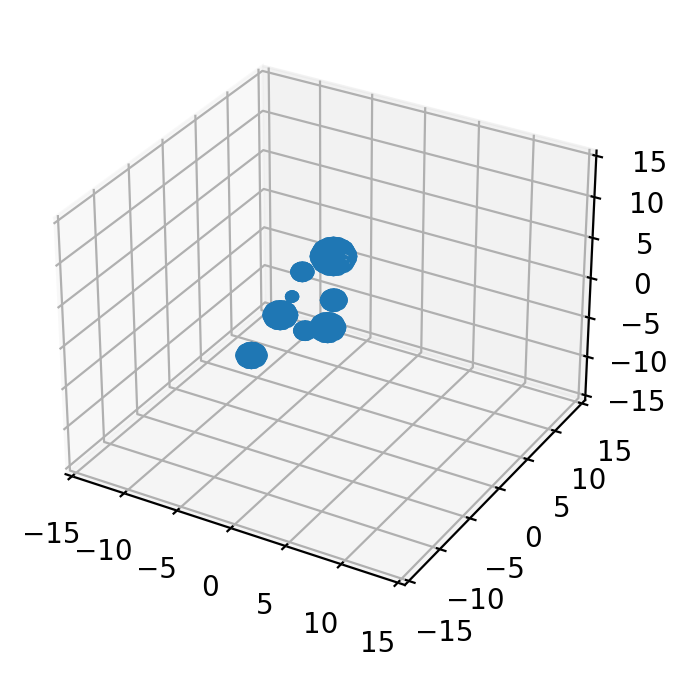

In [18]:
pt = randomBox(10,3,10,0,10,0)
#size = 
initPlot()
plot(pt,12)

Simulation began on:  2021-12-02 13:08:50.296708
Simulation ended on:  2021-12-02 13:19:49.316992
Elapsed Time:  0:10:59.020284


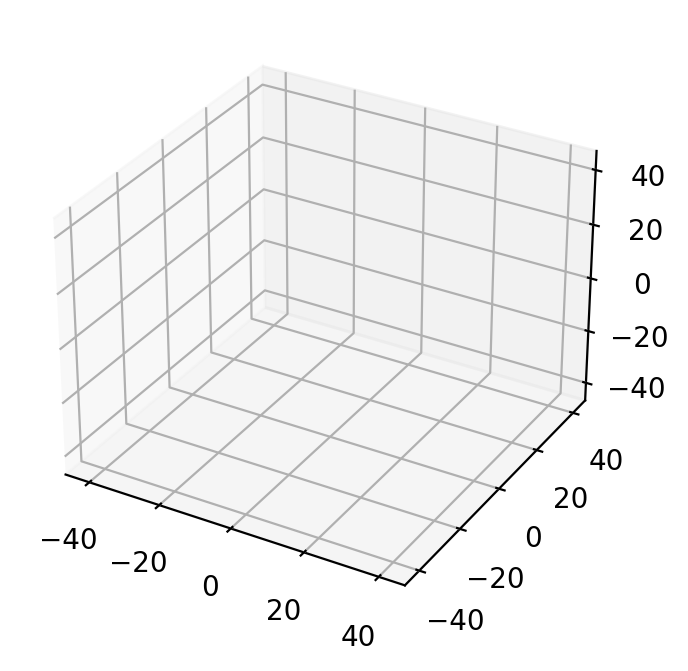

In [32]:
pt = randomBox(50,3,10,0,10,0)
size = 30
simulate('Spiral 50.mp4', 60, 40, pt, fSpiral, 1e-8, 50000)